<a href="https://colab.research.google.com/github/markerenberg/Toxic-Comment-Classification/blob/master/RandomForest_SMOTE_SMBO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Check if GPU is enabled
import tensorflow as tf
tf.test.gpu_device_name()

# Check how much RAM is available
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

In [1]:
##
## =======================================================
## Mark Erenberg 
## Toxic Comment Classification Challenge
## =======================================================
##

# Objective: Create a model which predicts a probability of each type of toxicity for each comment.

# import dependencies and files

import os
import time
import pandas as pd
import numpy as np
from scipy import sparse
from scipy.sparse import hstack
import itertools
import matplotlib.pyplot as plt
import re
import tempfile
import warnings
import ast

import lightgbm as lgb
import xgboost as xgb

import nltk
#nltk.download()
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag, word_tokenize

import gensim
import gensim.models.keyedvectors as word2vec
from gensim.models.fasttext import FastText
from gensim.models.word2vec import Word2Vec
import gensim.downloader as api

import spacy
import en_core_web_sm
spacy_nlp = en_core_web_sm.load()
spacy_nlp = spacy.load('en_core_web_sm')
from spacy.lemmatizer import Lemmatizer

from collections import Counter, defaultdict

from sklearn import utils
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, average_precision_score, classification_report, confusion_matrix,r2_score, roc_curve, make_scorer,accuracy_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Bidirectional, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.optimizers import Adam
from keras.callbacks import Callback

from imblearn.over_sampling import SMOTE, SVMSMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, space_eval


################### Data Loading ###################
#os.chdir('C:\\Users\\marke\\Downloads\\Toxic Classification')
train = pd.read_csv('train.csv').fillna('')
test = pd.read_csv('test.csv').fillna('')

train_text = train[['id','comment_text']].drop_duplicates()
df = pd.concat([train_text,test],axis=0,ignore_index=True)

################### Load Spell Check ###################
# Load word2vec model pre-trained on Google News corpus (3 billion running words) 
"""
t0 = time.time()
google = api.load('word2vec-google-news-300')

words = google.index2word

w_rank = {}
for i,word in enumerate(words):
    w_rank[word] = i
WORDS = w_rank

def words(text): return re.findall(r'\w+', text.lower())

def P(word): 
    "Probability of `word`."
    # use inverse of rank as proxy
    # returns 0 if the word isn't in the dictionary
    return - WORDS.get(word, 0)

def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

print("Time taken to load SpellChecker: {}m".format(round((time.time()-t0)/60,2)))
"""
################### Data Cleaning ####################
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')
cv = CountVectorizer(min_df=0., max_df=1.)
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

# Simple way to get the number of occurence of a regex
def count_regexp_occ(regexp="", text=None):
    return len(re.findall(regexp, text))

# Determine if file words exist:
#print(len(df[df['comment_text'].str.contains('jpg')]))
#print(len(df[df['comment_text'].str.contains('jpeg')]))
#print(len(df[df['comment_text'].str.contains('http')]))
#print(len(df[df['comment_text'].str.contains('pdf')]))
#print(len(df[df['comment_text'].str.contains('html')]))

# Remove non-alphabetic characters and split tokens by spaces/newlines
def clean_document(doc,use_stop=True):
    # 1) Convert string to lower
    #doc = bytes(doc.lower(), encoding="utf-8")
    doc = doc.lower()
    # 2) Replace contracion patterns
    cont_patterns = [
    (r'(W|w)on\'t', r'will not'),
    (r'(C|c)an\'t', r'can not'),
    (r'(I|i)\'m', r'i am'),
    (r'(A|a)in\'t', r'is not'),
    (r'(\w+)\'ll', r'\g<1> will'),
    (r'(\w+)n\'t', r'\g<1> not'),
    (r'(\w+)\'ve', r'\g<1> have'),
    (r'(\w+)\'s', r'\g<1> is'),
    (r'(\w+)\'re', r'\g<1> are'),
    (r'(\w+)\'d', r'\g<1> would'),
    ]
    patterns = [(re.compile(regex), repl) for (regex, repl) in cont_patterns]
    for (pattern, repl) in patterns:
        doc = re.sub(pattern, repl, doc)
    # 3) Remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]+', r' ', doc)
    # 4) Remove extra whitespaces
    doc = re.sub(r"\s+",r" ",doc)
    # 5) Remove leading/trailing whitespaces
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    if use_stop:
      # filter stopwords out of document
      filtered_tokens = [token for token in tokens if token not in stop_words]
    else:
      filtered_tokens = tokens
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    #doc = ' '.join(tokens)
    return doc

# Old-school lemmatization
def lemmatize_comment(comment):
        doc = spacy_nlp(comment)
        return [token.lemma_ for token in doc if token.lemma_ != '-PRON-']         

# Spell-check, then lemmatize
def spell_and_lemmatize(doc,lemmatize=True):
    # 1) Replace contraction patterns
    cont_patterns = [
    (r'(W|w)on\'t', r'will not'),
    (r'(C|c)an\'t', r'can not'),
    (r'(I|i)\'m', r'i am'),
    (r'(A|a)in\'t', r'is not'),
    (r'(\w+)\'ll', r'\g<1> will'),
    (r'(\w+)n\'t', r'\g<1> not'),
    (r'(\w+)\'ve', r'\g<1> have'),
    (r'(\w+)\'s', r'\g<1> is'),
    (r'(\w+)\'re', r'\g<1> are'),
    (r'(\w+)\'d', r'\g<1> would'),
    ]
    patterns = [(re.compile(regex), repl) for (regex, repl) in cont_patterns]
    for (pattern, repl) in patterns:
        doc = re.sub(pattern, repl, doc)
    # 2) Remove special characters, replace newlines with spaces, remove extra spaces
    doc = re.sub(r'[^a-zA-Z\s]+', ' ', doc)
    doc = re.sub(r'[\n\r\t\r\n]',r' ',doc,re.I|re.U)
    doc = re.sub(r"\s+",r" ",doc)
    # 3) Remove leading and trailing whitespaces
    doc = doc.strip()
    # 4) Filter only verbs, nouns, adjectives, and adverbs. Remove stopwords.
    filtered = [token.text for token in spacy_nlp(doc) if token.pos_ in ['VERB','NOUN','ADJ','ADV','PROPN'] and token.text.lower() not in stop_words]
    # 5) Spell-check words that are not proper nouns
    corrected = [correction(token.text) if token.pos_ != 'PROPN' else token.text for token in spacy_nlp(" ".join(filtered))]
    if lemmatize == True:
      # 6) Apply lemmatization to spell-checked words
      lemmas = [token.lemma_ if token.pos_ != 'PROPN' else token.text for token in spacy_nlp(" ".join(corrected))]
      # 7) Remove pronouns, convert to lowercase
      final_lemmas = [token.text.lower() for token in spacy_nlp(" ".join(lemmas)) if token.lemma_ != '-PRON-']
      return final_lemmas
    else:
      return [text.lower() for text in corrected]

## Clean and lemmatize comments
#df['clean_comments'] = [clean_document(x) for x in df['comment_text']]
#df['clean_comments_list'] = df['clean_comments'].apply(lambda x: x.split())
#df['clean_lemmed'] = [lemmatize_comment(x) for x in df['clean_comments']]
#df['clean_lemmed_str'] = df['clean_lemmed'].apply(lambda x: " ".join(x))
#train['clean_comments'] = [clean_document(x) for x in train['comment_text']]
#train['clean_comments_list'] = train['clean_comments'].apply(lambda x: x.split())
#train['clean_lemmed'] = [spell_and_lemmatize(x,lemmatize=True) for x in train['comment_text']]
#train['clean_lemmed_str'] = train['clean_lemmed'].apply(lambda x: " ".join(x))
#train['clean_spelled'] = [spell_and_lemmatize(x,lemmatize=False) for x in train['comment_text']]
#train['clean_spelled_str'] = train['clean_spelled'].apply(lambda x: " ".join(x))

## Write to csv for download
#from google.colab import drive
#drive.mount('/content/drive')
#train['clean_comments'].to_csv('train_clean_comments.csv',sep=',',index=False)
#train['clean_lemmed_str'].to_csv('train_clean_lemmed.csv',sep=',',index=False)
#train['clean_spelled_str'].to_csv('train_clean_spelled.csv',sep=',',index=False)

## Read from csv
train_clean_comments = pd.read_csv('train_clean_comments.csv',header=None)
train_clean_lemmed = pd.read_csv('train_clean_lemmed.csv',header=None)
train_clean_spelled = pd.read_csv('train_clean_spelled.csv',header=None)


## Transform cleaned/lemmed strings
train['clean_comments'] = train_clean_comments[0].apply(lambda x: str(x))
train['clean_comments_list'] = train['clean_comments'].apply(lambda x: x.split())
#train['clean_lemmed'] = train_clean_lemmed[0].apply(lambda x: str(x))
#train['clean_lemmed_list'] = train['clean_lemmed'].apply(lambda x: x.split())
train['clean_lemmed'] = train_clean_lemmed[0].apply(lambda x: ast.literal_eval(x))
train['clean_lemmed_str'] = train['clean_lemmed'].apply(lambda x: " ".join(x))
train['clean_spelled'] = train_clean_spelled[0].apply(lambda x: str(x))
train['clean_spelled_list'] = train['clean_spelled'].apply(lambda x: x.split())

## Read in test data
test = pd.read_csv("test.csv")
test_labels = pd.read_csv("test_labels.csv")
test = pd.merge(test,test_labels,on='id')
test = test[test['toxic']>=0].reset_index(drop=True)
test_clean_comments = pd.read_csv('test_clean_comments.csv',header=None)
test['clean_comments'] = test_clean_comments[0].apply(lambda x: str(x))
test['clean_comments_list'] = test['clean_comments'].apply(lambda x: x.split())
#test_clean_spelled = pd.read_csv('test_clean_spelled.csv',header=None)
#test['clean_spelled'] = test_clean_spelled[0].apply(lambda x: str(x))
#test['clean_spelled_list'] = test['clean_spelled'].apply(lambda x: x.split())


class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
######### SPELL CHECK + CLEAN TEST DOCUMENTS ########
# 3) Clean data
#test['clean_comments'] = [clean_document(x,use_stop=True) for x in test['comment_text']]
#test['clean_comments_list'] = test['clean_comments'].apply(lambda x: x.split())
#test['clean_comments'].to_csv("test_clean_comments.csv",index=False)
#print("----- CORPUS CLEAN COMPLETE -----")
test['clean_spelled'] = [spell_and_lemmatize(x,lemmatize=False) for x in test['comment_text']]
test['clean_spelled_str'] = test['clean_spelled'].apply(lambda x: " ".join(x))
test['clean_spelled_str'].to_csv("test_clean_spelled.csv",index=False)
print("----- SPELL CHECK COMPLETE -----")

In [0]:
# Set parameters
lgb_params = {
    "objective": "binary",
    'metric': 'binary_error',
    'is_unbalance': True,
    "boosting_type": "gbdt",
    "verbosity": -1,
    "num_threads": -1,
    "bagging_fraction": 0.8,
    "feature_fraction": 0.8,
    "learning_rate": 0.1,
    "reg_lambda":0,
    "num_leaves": 31,
    "verbose": -1
}

xgb_params = {
    "objective": "binary:logistic",
    'eval_metric': 'map',
    "booster": "gbtree",
    "verbosity": 0,
    "subsample": 0.7,
    "colsample_bytree": 0.7,
    "learning_rate": 0.1,
    "lambda":1,
    "num_leaves": 31
}


rf_params = {
    "n_estimators":100,
    "max_depth":None,
    "max_features":"auto",
    "min_samples_split":2,
    "min_samples_leaf":1,
    "bootstrap":True,
    "verbose":0,
    "class_weight":"balanced"
}

In [0]:
#################### Define functions for featrue engineering ####################
# Define all our functions + vectorizers
word_vectorizer = TfidfVectorizer(
    #min_df = 3,
    #max_df = 0.9,
    sublinear_tf=True,
    #smooth_idf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 2),
    max_features=20000)

char_vectorizer = TfidfVectorizer(
    #min_df = 3,
    #max_df = 0.9,
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    stop_words='english',
    ngram_range=(2, 6),
    max_features=20000)

def add_features(df):
    # Get length in words and characters
    df["word_count"] = df["comment_text"].apply(lambda x: len(x.split()))
    df["word_len_avg"] = df["comment_text"].apply(lambda x: np.mean([len(x) for x in x.split()]))
    df["word_len_std"] = df["comment_text"].apply(lambda x: np.std([len(x) for x in x.split()]))
    df["char_count"] = df["comment_text"].apply(lambda x: len(x))
    # Create count variables to see if any are useful
    df["upper_ratio"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[A-Z]", x)) /df['char_count']*100
    df["number_ratio"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[0-9]", x)) / df["char_count"] *100
    df["excl_ratio"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"\!", x)) / df["char_count"] *100
    df["quest_ratio"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"\?", x)) / df["char_count"] *100
    df["equals_ratio"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"\=", x)) / df["char_count"] *100
    df["punct_ratio"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[\.\!\?\=\+\#\*\|\~\-\,]", x)) / df["char_count"] *100
    df["you_ratio"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"\W[Yy][oO][uU]\W", x)) / df["word_count"] *100
    df["nb_fuck"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[Ff][uU][cC][Kk]", x))
    df["nb_shit"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[Ss][Hh][Ii][Tt]", x))
    df["nb_kill"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[kK][iI][lL][lL]", x))
    df["nb_die"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"\s[dD][iI][eE]\s", x))
    df["nb_suck"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[Ss]\S{2}[Kk]", x))
    df["nb_dick"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[dD][iI][cC][kK]", x))
    df["nb_penis"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[pP][eE][nN][iI][sS]", x))
    df["nb_pussy"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[pP][uU][sS][sS][yY]", x))
    df["nb_cock"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[cC][oO][cC][kK]", x))
    df["8==D"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"8=+D", x))
    df["nb_piss"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[pP][iI][sS][sS]", x))
    df["nb_gay"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[gG][aA][yY]", x))
    df["nb_bitch"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[bB][iI][tT][cC][hH]", x))
    df["nb_retard"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[rR][eE][tT][aA][rR][dD]", x))
    df["nb_cunt"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[cC][uU][nN][tT]", x))
    df["nb_idiot"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[iI][dD][iI][oO][tT]", x))
    df["nb_stupid"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[sS][tT][uU][pP][iI][dD]", x))
    df["nb_dumb"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[dD][uU][mM][bB]", x))
    df["nb_shut_up"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[sS][hH][uU][tT]\s[uU][pP]", x))
    df["nb_mother"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"\s[mM][oO][tT][hH][eE][rR](\W|\s|$)", x))
    df["nb_ng"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"\s[nN][iI][gG][gG][eE][rR](\W|\s|$)", x))
    df["nb_fat"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"\s[Ff][aA][tT](\W|\s|$)", x))
    df["nb_ass"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"((\W|\s|$)[aA][sS][sS]\w)|(\w[aA][sS][sS](\W|\s|$))", x))
    df["nb_fg"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[fF][aA][gG][gG][oO][tT]", x))
    df["nb_fg_2"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"\s[fF][aA][gG](\W|\s|$)", x))
    df["nb_cancer"] = df["comment_text"].apply(lambda x: count_regexp_occ(r"[cC][aA][nN][cC][eE][rR]", x))
    return df

def pos_tagging(df):
    df["comment_raw"] = df["comment_text"].apply(lambda x: re.sub(r'[\n\r\t\r\n]',r' ',x,re.I|re.U))
    df["POS"] = df["comment_raw"].apply(lambda x: [token.pos_ for token in spacy_nlp(x)])
    return df
    
def pos_features(df):
    # Get number of proper nouns
    df["PROPN"] = df["POS"].apply(lambda x: len([pos for pos in x if pos == 'PROPN']))
    df["ADJ"] = df["POS"].apply(lambda x: len([pos for pos in x if pos == 'ADJ']))
    df["INTJ"] = df["POS"].apply(lambda x: len([pos for pos in x if pos == 'INTJ']))
    df["SYM"] = df["POS"].apply(lambda x: len([pos for pos in x if pos == 'SYM']))
    return df

def count_duplicates(seq): 
    '''
    takes as argument a sequence and returns the number of duplicate elements
    ex: count_duplicates(["hello world.","hello world.","hello world."]) -> 2
    ex: count_duplicates(["hello world","fuck disneyland","hello world"]) -> 1
    '''
    return len(seq) - len(set(seq))

def count_non_duplicates(seq):
  '''
  takes as argument a list of words, and returns the percentage of words that are duplicates
  '''
  if len(set(seq)) == 0: return 0
  count_dict = Counter(seq)
  dup_words = [word for (word,count) in count_dict.items() if count >= 2]
  return len(dup_words)/len(set(seq))

def feature_engineering(df,text_col):
  # Declare text column
  train = df.copy()
  train_text = train[text_col]
  # Create TF-IDF features
  word_vectorizer.fit(train_text)
  char_vectorizer.fit(train_text)
  train_word_features = word_vectorizer.transform(train_text)
  train_char_features = char_vectorizer.transform(train_text)
  tfidf_features = hstack([train_char_features, train_word_features]).tocsr()
  # Create metadata + POS features
  train = add_features(train)
  train = pos_tagging(train)
  train = pos_features(train)
  # Create spam features
  comment_counts = train[text_col].value_counts().to_dict()
  train['is_duplicate'] = train[text_col].apply(lambda x: int(comment_counts[x]>1))
  train['comment_list'] = train['comment_text'].apply(lambda x: (clean_document(x,use_stop=True)).split())
  train['is_spam'] = train['comment_list'].apply(lambda x: int(count_non_duplicates(x)>=0.5))
  # Combine metadata + POS + spam + TF-IDF features
  meta_features = train.drop(['id','comment_text','clean_comments','clean_comments_list','clean_lemmed','clean_lemmed_str','clean_lemmed_list','clean_spelled','clean_spelled_list','comment_raw','POS','sentence_list','repeated_sentences','comment_list']+class_names,axis=1,inplace=False,errors='ignore')
  train_features = hstack([sparse.csr_matrix(meta_features.values), tfidf_features]).tocsr()
  return train_features

def plot_confusion_matrix(cm,target_names,title='Confusion matrix',fontsize=10,cmap=None,normalize=True):
      accuracy = np.trace(cm) / float(np.sum(cm))
      misclass = 1 - accuracy
      if cmap is None:
          cmap = plt.get_cmap('Blues')
      plt.figure(figsize=(8,8))
      plt.imshow(cm, interpolation='nearest', cmap=cmap)
      plt.title(title,fontsize=fontsize)
      plt.colorbar()
      if target_names is not None:
          tick_marks = np.arange(len(target_names))
          plt.xticks(tick_marks, target_names, rotation=45,fontsize=fontsize)
          plt.yticks(tick_marks, target_names,fontsize=fontsize)
      if normalize:
          cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      thresh = cm.max() / 1.5 if normalize else cm.max() / 2
      for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
          if normalize:
              plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                      horizontalalignment="center",
                      color="white" if cm[i, j] > thresh else "black",
                      fontsize=fontsize)
          else:
              plt.text(j, i, "{:,}".format(cm[i, j]),
                      horizontalalignment="center",
                      color="white" if cm[i, j] > thresh else "black",
                      fontsize=fontsize)
      plt.tight_layout()
      plt.ylabel('True label',fontsize=fontsize)
      plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass),fontsize=fontsize)
      plt.show()  

In [3]:
######### PERFORM FEATURE ENGINEERING ########
train_features = feature_engineering(train,'clean_comments')
test_features = feature_engineering(test,'clean_comments')
print("----- Feature Engineering Completed! -----")

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:520: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn("The parameter 'stop_words' will not be used"
/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:520: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn("The parameter 'stop_words' will not be used"


----- Feature Engineering Completed! -----


In [8]:
test_features.shape

(63978, 40043)

In [0]:
##### Bayesian Hyperparameter Tuning for RF + SMOTE #####

warnings.filterwarnings("ignore")

# Define variables for CV
seed = 16
splits = 5
folds = StratifiedKFold(n_splits=splits, shuffle=True, random_state=seed)

# Define response class
resp = 'severe_toxic'
training_labels = train[resp]

### Define functions for Bayesian Hyperparameter Optimization (SMBO using TPE)

# 1) Define objective 

def objective(params):
    time1 = time.time()
    over = SMOTE(sampling_strategy=params['over_ratio'],k_neighbors=params['over_neighbors'],random_state=seed)
    under = RandomUnderSampler(sampling_strategy=params['under_ratio'],random_state=seed)
    
    print("\n############## New Run ################")
    print(f"params = {params}")
    score_mean = 0
    class_pred = np.zeros(train_features.shape[0])

    #=========== Perform 5-fold CV, score using Recall ===========#
    for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train_features, training_labels)):
      #------------ Transform features ----------#
      X_re, y_re = over.fit_resample(train_features[trn_idx],training_labels[trn_idx])
      X_re, y_re = under.fit_resample(X_re,y_re)   
     
      #------ Train model, make predictions -----#
      model = RandomForestClassifier(n_estimator=params['n_estimators'],
                                     max_depth=int(params['max_depth']),
                                     max_features=params['max_features'],
                                     min_samples_split=params['min_samples_split'],
                                     min_samples_leaf=params['min_samples_leaf'],
                                     bootstrap=params['bootstrap'],
                                     verbose=0,
                                     n_jobs=-1,
                                     class_weight="balanced"
                                     )
      model.fit(X_re, y_re)
      class_pred[val_idx] = model.predict_proba(train_features[val_idx])[:,1]
      #--- Identify Optimal Threshold for Predictions ---#
      auc.append(roc_auc_score(training_labels[val_idx], class_pred[val_idx],average='weighted'))
      prec, recal, thresh = precision_recall_curve(training_labels[val_idx], class_pred[val_idx])
      precision.append(prec)
      recall.append(recal)
      thresholds.append(thresh)
      fscore = (2 * prec * recal) / (prec + recal)
      ix = np.argmax(fscore)
      best_t = thresh[ix]
      #--- Calculate recall score for optimal threshold ---#
      preds=(class_pred[val_idx]>= thresh[ix]).astype(int)
      score = recall_score(training_labels[val_idx],preds],average='weighted')
      score_mean += score
    time2 = time.time() - time1
    print(f"Total Time Run: {round(time2 / 60,2)}")
    #gc.collect()
    print(f'Average Recall Score: {score_mean/splits}')
    return -(score_mean / splits)


# 2) Define search space

space = {    
    # Define hyperparameters for RF + SMOTE
    'n_estimators': hp.uniform('n_estimators',100,1000),
    'max_depth': hp.choice('max_depth',[2,5,8,10,12,15,18,20,None]),
    'max_features': hp.choice('max_features',[0.001,0.0025,0.005,0.01,0.02,"auto",None]),
    'min_samples_split': hp.uniform('min_samples_split',2,10),
    'min_samples_leaf': hp.uniform('min_samples_split',1,10),
    'bootstrap': hp.choice('bootstrap',[True,False]),
    'over_ratio': hp.uniform('over_ratio',0.01,0.5),
    'over_neighbors': hp.choice('over_neighbors',[5,10,15,20]),
    'under_ratio': hp.uniform('under_ratio',0.25,0.75)
}

# 3) Specify Optimization algorithm
tpe_algo = tpe.suggest

# 4) Instantiate Trials object to track results
tpe_trials = Trials()

# Set hyperopt parameters
best = fmin(fn=objective,
            space=space,
            algo=tpe_algo,
            trials = tpe_trials,
            max_evals=100)
# Print best parameters
best_params = space_eval(space, best)
print("BEST PARAMS: ", best_params)


--------- FINAL CLASSIFICATION REPORT CLASS: toxic ---------
              precision    recall  f1-score   support

           0       0.94      0.76      0.84     57888
           1       0.19      0.52      0.28      6090

    accuracy                           0.74     63978
   macro avg       0.56      0.64      0.56     63978
weighted avg       0.87      0.74      0.79     63978

Class:  toxic  | Final AUC:  0.705
Class:  toxic  | Final F-Score:  0.279


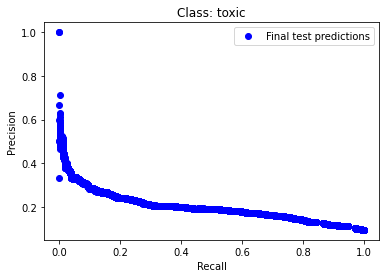

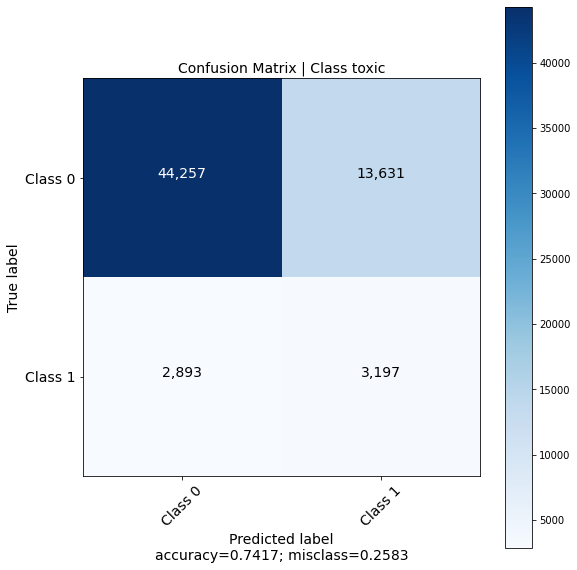

--------- FINAL CLASSIFICATION REPORT CLASS: severe_toxic ---------
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     63611
           1       0.24      0.10      0.14       367

    accuracy                           0.99     63978
   macro avg       0.62      0.55      0.57     63978
weighted avg       0.99      0.99      0.99     63978

Class:  severe_toxic  | Final AUC:  0.7938
Class:  severe_toxic  | Final F-Score:  0.1439


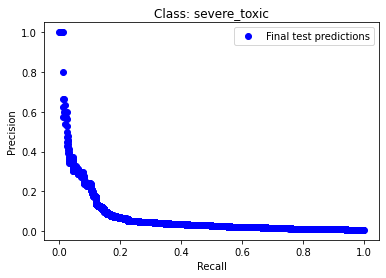

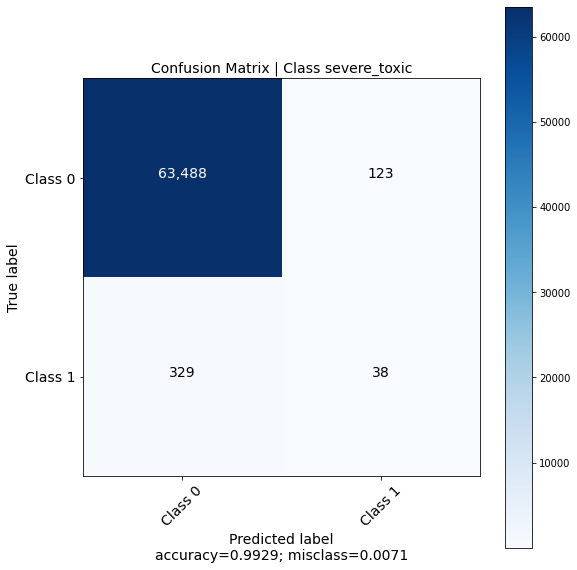

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


--------- FINAL CLASSIFICATION REPORT CLASS: obscene ---------
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     60287
           1       0.00      0.00      0.00      3691

    accuracy                           0.94     63978
   macro avg       0.47      0.50      0.49     63978
weighted avg       0.89      0.94      0.91     63978

Class:  obscene  | Final AUC:  0.7362
Class:  obscene  | Final F-Score:  nan


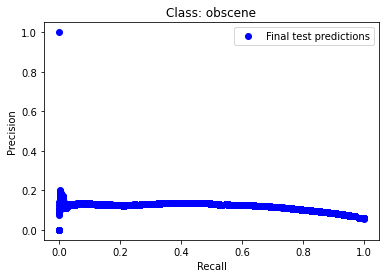

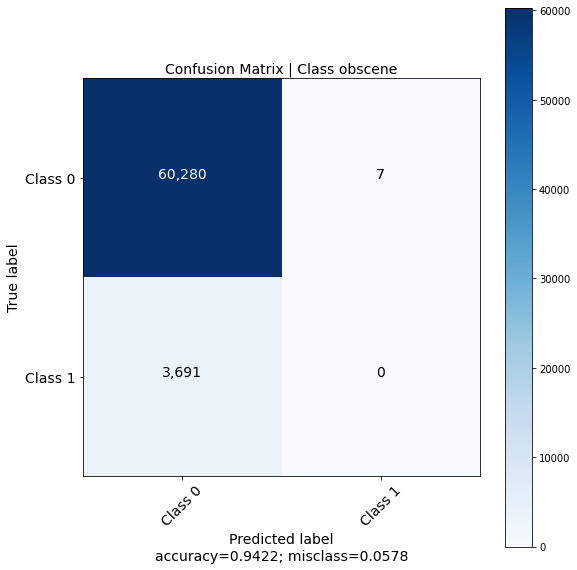

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


--------- FINAL CLASSIFICATION REPORT CLASS: threat ---------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     63767
           1       0.00      0.00      0.00       211

    accuracy                           1.00     63978
   macro avg       0.50      0.50      0.50     63978
weighted avg       0.99      1.00      1.00     63978

Class:  threat  | Final AUC:  0.7823
Class:  threat  | Final F-Score:  nan


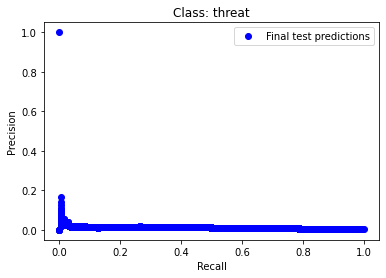

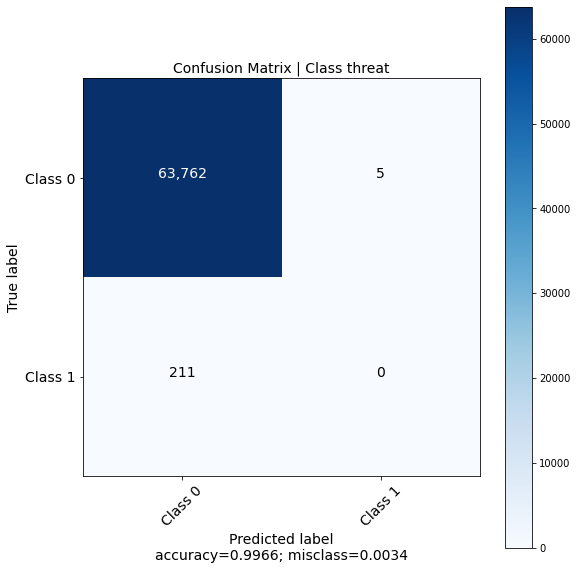

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


--------- FINAL CLASSIFICATION REPORT CLASS: insult ---------
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     60551
           1       0.00      0.00      0.00      3427

    accuracy                           0.95     63978
   macro avg       0.47      0.50      0.49     63978
weighted avg       0.90      0.95      0.92     63978

Class:  insult  | Final AUC:  0.737
Class:  insult  | Final F-Score:  nan


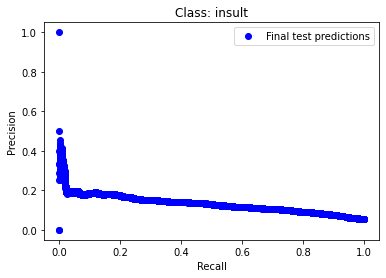

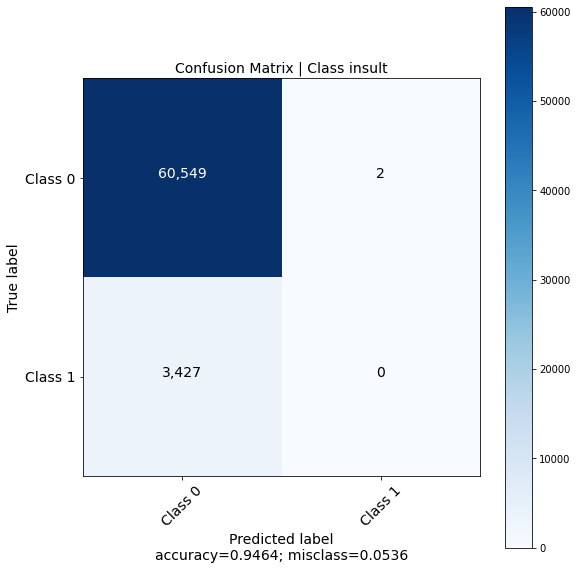

--------- FINAL CLASSIFICATION REPORT CLASS: identity_hate ---------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     63266
           1       0.00      0.00      0.00       712

    accuracy                           0.99     63978
   macro avg       0.49      0.50      0.50     63978
weighted avg       0.98      0.99      0.98     63978

Class:  identity_hate  | Final AUC:  0.7315
Class:  identity_hate  | Final F-Score:  nan


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


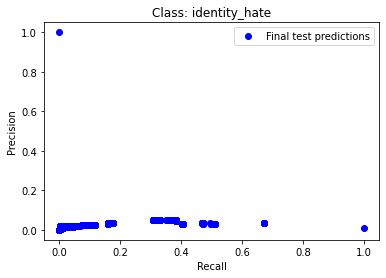

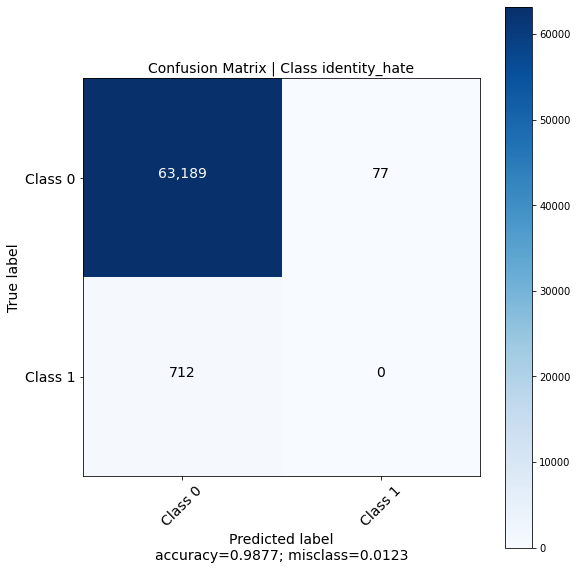

In [0]:
######### PREDICT LABELS FOR TEST CLASS ########
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Make predictions for each class
for resp in class_names:
  #resp = 'severe_toxic'
  training_labels = train[resp]
  test_labels = test[resp]
  seed = 1234
  splits = 5
  folds = StratifiedKFold(n_splits=splits, shuffle=True, random_state=seed)
  # 6) Train model
  X_train = train_features
  y_train = training_labels
  X_test = test_features
  y_test = test_labels
  dtrain = xgb.DMatrix(X_train,label=y_train) 
  dval =  xgb.DMatrix(X_test,label=y_test) 
  watchlist = [(dtrain,'train'), (dval, 'valid')]
  xgb_rounds=200
  #weight_ratio = np.sum(X_re == 0) / np.sum(y_re == 1)
  #print("Weight ratio: ",weight_ratio)
  #xgb_params['scale_pos_weight'] = weight_ratio 
  model = xgb.train(params=xgb_params,
                    dtrain=dtrain,
                    num_boost_round=xgb_rounds,
                    evals=watchlist,
                    early_stopping_rounds=50,
                    verbose_eval=False)
  # 7) Make predictions
  pred_probs = model.predict(xgb.DMatrix(X_test), ntree_limit = model.best_ntree_limit)
  # 8) Evaluate predictions
  auc = roc_auc_score(y_test, pred_probs,average='weighted')
  prec, recal, thresh = precision_recall_curve(y_test, pred_probs)
  fscore = (2 * prec * recal) / (prec + recal)
  ix = np.argmax(fscore)
  #print('Final Predictions: ','Best Threshold=%f, F-Score=%.3f' % (thresh[ix], fscore[ix]))
  preds=(pred_probs>= thresh[ix]).astype(int)
  print("--------- FINAL CLASSIFICATION REPORT CLASS: {} ---------".format(resp))
  print(classification_report(y_test, preds))
  # 9) Print out mean AUC score, F-score
  print("Class: ",resp,' | Final AUC: ',str(round(auc,4)))
  print("Class: ",resp,' | Final F-Score: ',str(round(fscore[ix],4)))
  #print("Best threshold: ",str(round(thresh[ix],4)))
  # 10) Plot precision-recall curve
  plt.figure()
  plt.plot(recal, prec, 'bo', linewidth=2,label='Final test predictions')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Class: '+resp)
  plt.legend()
  plt.show()
  # 11) Plot confusion matrix
  plot_confusion_matrix(cm=confusion_matrix(y_test, preds), target_names=["Class 0","Class 1"],
                        title='Confusion Matrix | Class {}'.format(resp),
                        normalize=False,fontsize=14)


In [0]:
##### Make predictions using 5-fold CV and RF + SMOTE, plot PR curve#####
resp = 'severe_toxic'
training_labels = train[resp]
seed = 1234
splits = 5
folds = StratifiedKFold(n_splits=splits, shuffle=True, random_state=seed)
use_smote=False

## Over_sampling and under_sampling
over_ratios = [0.05,0.1,0.2]
#under_ratios = [0.025,0.05,0.1,0.15]

#for ratio in over_ratios:
# Define new re-sampled data
class_pred = np.zeros(train_features.shape[0])
# Use 5-fold cross-validation to evaluate performance at given over-sampling ratio.
auc,precision,recall,thresholds,f_scores,best_t = [],[],[],[],[],[]
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train_features, training_labels)):
  if use_smote:
    # Define pipeline to oversample, undersample, and then cross-validate
    over = SMOTE(sampling_strategy=0.05,k_neighbors=10)
    #under = TomekLinks(sampling_strategy='majority')
    #under = RandomUnderSampler(sampling_strategy=ratio)
    #steps = [('over', over), ('under', under), ('model', model)]
    #pipeline = Pipeline(steps=steps)
    # evaluate pipeline
    X_re, y_re = over.fit_resample(train_features[trn_idx],training_labels[trn_idx])
    #X_re, y_re = under.fit_resample(X_re,y_re)   
    X_train = X_re
    y_train = y_re
  else:
    X_train =  train_features[trn_idx]
    y_train = training_labels[trn_idx]
  # Train model, make predictions
  model = RandomForestClassifier(n_estimators=200,
                                 class_weight='balanced',
                                 random_state=seed,
                                 n_jobs=-1)
  model.fit(X_train, y_train)
  class_pred[val_idx] = model.predict_proba(train_features[val_idx])[:,1]
  # Evaluate model using AUC,Prec,Recall,Fscore
  auc.append(roc_auc_score(training_labels[val_idx], class_pred[val_idx],average='weighted'))
  prec, recal, thresh = precision_recall_curve(training_labels[val_idx], class_pred[val_idx])
  precision.append(prec)
  recall.append(recal)
  thresholds.append(thresh)
  # Find optimal threshold
  fscore = (2 * prec * recal) / (prec + recal)
  # locate the index of the largest f score
  ix = np.argmax(fscore)
  print('Fold ', n_fold, ':','Best Threshold=%f, F-Score=%.3f' % (thresh[ix], fscore[ix]))
  best_t.append(thresh[ix])
  f_scores.append(fscore[ix])
  # Print classification report using best threshold (as identified thru CV)
  preds=(class_pred[val_idx]>= thresh[ix]).astype(int)
  print("--------- FOLD {} CLASSIFICATION REPORT ---------".format(n_fold))
  print(classification_report(training_labels[val_idx], preds))
  #### MISTAKES WERE MADE ####
  #y_val = training_labels[val_idx]
  #true_comments = [train['comment_text'][idx] for idx in y_val.index]
  #y_trues = y_val.reset_index(drop=True)
  #errors = pd.Series([preds.item(idx) for idx in range(len(preds)) if preds.item(idx) != y_trues[idx]])
  #error_comments = pd.Series([true_comments[idx] for idx in range(len(preds)) if preds.item(idx) != y_trues[idx]])
  #error_df = pd.DataFrame({'Errors':errors,'Comments':error_comments})
  #error_df.to_csv("{}_errors_fold{}.csv".format(resp,n_fold),index=False)

# Print out mean AUC score
print("Class: ",resp,' | mean AUC: ',str(round(np.mean(auc),4)))
print("Class: ",resp,' | mean F-Score: ',str(round(np.mean(f_scores),4)))
print("Avg best threshold: ",str(round(np.mean(best_t),4)))
# Plot precision-recall curve
plt.figure()
plt.plot(recall[0], precision[0], 'ro', linewidth=2,label='Fold 1 Preds')
plt.plot(recall[1], precision[1], 'bo', linewidth=2,label='Fold 2 Preds')
plt.plot(recall[2], precision[2], 'go', linewidth=2,label='Fold 3 Preds')
plt.plot(recall[3], precision[3], 'yo', linewidth=2,label='Fold 4 Preds')
plt.plot(recall[4], precision[4], 'mo', linewidth=2,label='Fold 5 Preds')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Class: '+resp+' | Average Precision: '+str(average_precision_score(training_labels,class_pred,average='weighted')))
plt.legend()
plt.show()
